# QAOA with Amazon Braket Hybrid Jobs and PennyLane

In this tutorial, we use PennyLane within Amazon Braket Hybrid Jobs to run the Quantum Approximate Optimization Algorithm (QAOA) on a Max-Cut problem.

## Learning outcomes
* Use pre-built PennyLane containers in Braket Jobs
* Set QAOA hyperparameters 
* Choose PennyLane backend (TensorFlow, PyTorch, Base)
* Use checkpoints for Braket Jobs

## QAOA background 

QAOA is a variational algorithm that uses parameterized quantum circuits to evaluate a classical cost function given by a binary optimization problem; the circuit parameters are iteratively adjusted to minimize the cost function. The QAOA algorithm itself has different settings, such as circuit depth ($p$). In analogy to machine learning, these input settings are commonly referred to as _hyperparameters_. In the following, we show how to setup the problem, prepare input data and run QAOA using Braket Jobs.

For more information about QAOA and PennyLane, see [this example notebook](../pennylane/2_Graph_optimization_with_QAOA.ipynb) or [this PennyLane tutorial](https://pennylane.ai/qml/demos/tutorial_qaoa_intro.html).

## Problem setup

A Max Cut problem is the problem to find a cut in a graph that maximizes the number of edges between the two parts after the cut. It has applications in theoretical physics and in combinatorial optimizations. To get started, we first create and visualize a random graph for the Max-Cut problem with <code>networkx</code> package. Feel free to adjust the number of nodes, <code>n</code>, and number of edges, <code>m</code> as part of your experiments.

In [1]:
import pennylane as qml
from pennylane import numpy as np
import networkx as nx

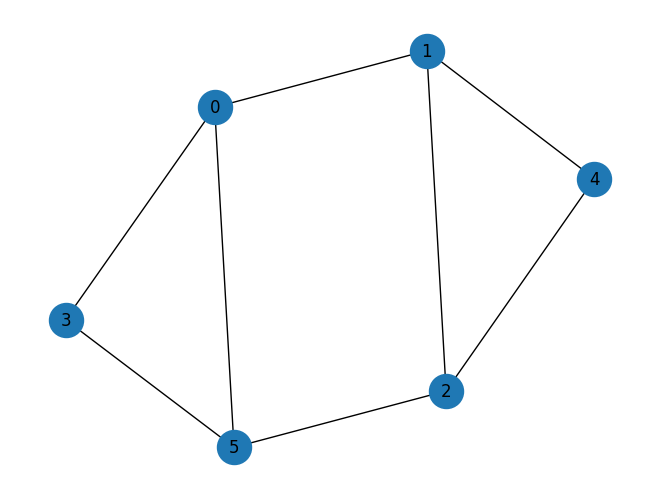

In [2]:
# We generate a random graph with num_nodes nodes and num_edges edges to run Max Cut on.
# num_nodes is the number of nodes in your graph, each represented by one qubit.
# Caution: Circuit runtimes will scale exponentially with num_nodes
num_nodes = 6
num_edges = 8
seed = 1967

graph = nx.gnm_random_graph(num_nodes, num_edges, seed=seed)

# Draw the graph
positions = nx.spring_layout(graph, seed=seed)
nx.draw(graph, with_labels=True, pos=positions, node_size=600)

## Prepare input data
We will prepare the optimization problem we want to solve, represented by the so-called Ising matrix, as the input data for the Braket Job. This best practice helps us decouple our problem definition from our algorithm code. If we want to solve another instance of this problem type, all we need to do is to point a new job to the new input data. The input data can be specified by either a path to a local file, or an Amazon S3 path that points to the data. For this example, we will create a file in the local directory encoding the problem graph.

In [3]:
input_file_path = "input-data.adjlist"

nx.write_adjlist(graph, input_file_path)

## Define the circuit

The ansatz represents a parameterized quantum circuit composed of alternating layers of a cost layer and a mixing layer. 
The number of qubits is equal to the number of nodes in the graph. 
We initialize the state to an even superposition over all basis states. 
For this example, we use a variational circuit consisting of `p=2` QAOA layers. 

Below, we use the QAOA utilities from PennyLane to construct the circuit ansatz. 

In [4]:
from pennylane import qaoa

p = 2 #  number of QAOA layers
wires = range(num_nodes) # number of qubits

params = np.random.rand(2, p) # random initial parameters

cost_h, mixer_h = qaoa.maxcut(graph)

dev = qml.device("default.qubit", wires=len(wires))


# Defines a layer of the QAOA ansatz from the cost and mixer Hamiltonians
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)


# Repeatedly applies layers of the QAOA ansatz
def circuit(params, **kwargs):
    p = params.shape[1]
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, p, params[0], params[1])

We can visualize the circuit with the built-in PennyLane drawing function

In [5]:
circuit(params)

(<Figure size 800x700 with 1 Axes>, <Axes: >)

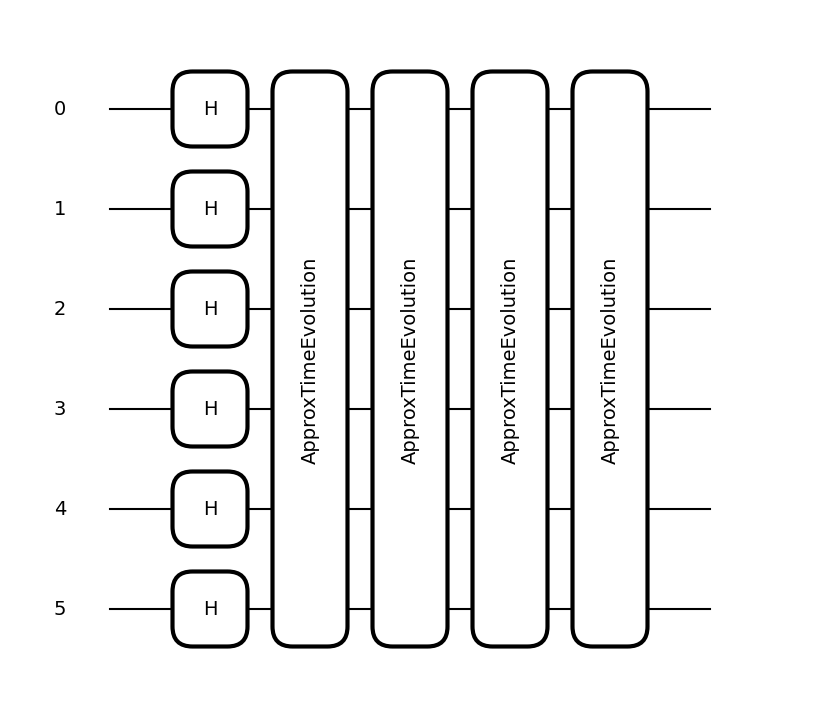

In [6]:
qml.draw_mpl(circuit)(params)

## Optimization with gradient descent

When solving the Max-Cut problem with QAOA, an optimizer updates the parameters in a parametrized circuit to minimize the cost function. While the parameters are updated in every iteration, the parametrized circuit is the same throughout the optimization process. 

We use the gradient descent optimizer from PennyLane to optimize the variational parameters in the circuit ansatz. 
Additionally, we print the value of the loss function at each training step using the `log_metric` function from `braket.jobs.metrics`.
This will be beneficial later so we can monitor training progress for long-running algorithms from the [Amazon Braket Console](https://console.aws.amazon.com/braket/home). 

In [7]:
from braket.jobs.metrics import log_metric
from braket.jobs import get_results_dir


def run_qaoa(p=1, steps=10):
    graph = nx.read_adjlist(input_file_path, nodetype=int)
    wires = list(graph.nodes)

    cost_h, mixer_h = qaoa.maxcut(graph)
    params = np.random.rand(2, p)

    @qml.qnode(dev)
    def cost_function(params):
        circuit(params)
        return qml.expval(cost_h)

    # training loop
    optimizer = qml.GradientDescentOptimizer()
    for i in range(steps):
        params = optimizer.step(cost_function, params)

        log_metric(metric_name="loss", value=cost_function(params), iteration_number=i)

    np.save("optimal_params.npy", params)

    return cost_function(params)

In [8]:
run_qaoa(p=1, steps=10)

Metrics - timestamp=1697309312.761493; loss=-4.210918032076299; iteration_number=0;
Metrics - timestamp=1697309312.8106694; loss=-4.258937677557162; iteration_number=1;
Metrics - timestamp=1697309312.8604462; loss=-4.314630341927151; iteration_number=2;
Metrics - timestamp=1697309312.9100215; loss=-4.377835596042916; iteration_number=3;
Metrics - timestamp=1697309312.9603245; loss=-4.44778126624406; iteration_number=4;
Metrics - timestamp=1697309313.0108266; loss=-4.523018760163052; iteration_number=5;
Metrics - timestamp=1697309313.0616252; loss=-4.601477491176784; iteration_number=6;
Metrics - timestamp=1697309313.11024; loss=-4.680662049689431; iteration_number=7;
Metrics - timestamp=1697309313.1595838; loss=-4.75796700271727; iteration_number=8;
Metrics - timestamp=1697309313.2208693; loss=-4.83103277626228; iteration_number=9;


tensor(-4.83103278, requires_grad=True)

Great! The training seems to be working since the cost function is decreasing in every iteration.

## Run as a hybrid job

Now let's run the algorithm asynchronously on Amazon Braket. 
We simply annotate the function with `@hybrid_job` and call it as usual. 
We also supply the input data set, in this case the graph information. 
For more information of hybrid jobs see the [documentation](https://docs.aws.amazon.com/braket/latest/developerguide/braket-jobs.html). 

Note that creating hybrid jobs with the `@hybrid_job` decorator is only supported on Python 3.10. 
For other versions, you may submit Python [scripts](https://docs.aws.amazon.com/braket/latest/developerguide/braket-jobs.html) or specify a [custom container image](https://docs.aws.amazon.com/braket/latest/developerguide/braket-jobs-byoc.html).


<div class="alert alert-block alert-info">
    <b>Note:</b> When using PennyLane with Braket QPU devices many training algorithms will benefit from enabling parametric compilation. When running hybrid job on a supported QPU, Braket will compile the circuit once, without the need to recompile for subsequent parameter updates to the same circuit, resulting up to 10x faster runtime. To learn more about parametric circuits, you can read the 
    <a href="https://docs.aws.amazon.com/braket/latest/developerguide/braket-jobs-parametric-compilation.html">Amazon Braket developer guide</a>
</div>

## Saving progress with checkpoints

It is best practice to regularly save interim progress of your hybrid job as checkpoints. If your hybrid job terminates unexpectedly, for instance, if a QPU becomes unavailable, you can create a new hybrid job and load its training progress from a checkpoint. 

The following is a minimal working example for saving and loading checkpoints with a hybrid job decorator:
```python
from braket.jobs import save_job_checkpoint, load_job_checkpoint, hybrid_job

@hybrid_job(device=None, wait_until_complete=True)
def function():
    save_job_checkpoint({"a": 1})

job = function()
job_name = job.name
job_arn = job.arn

@hybrid_job(device=None, wait_until_complete=True, copy_checkpoints_from_job=job_arn)
def continued_function():
    load_job_checkpoint(job_name)

continued_job = continued_function()
```

In the first hybrid job, we call `save_job_checkpoint` with a dictionary containing the data we want to save. 
By default, every value must be serializable as text. 
For checkpointing more complex Python objects, such as numpy arrays, you may set 
`data_format = PersistedJobDataFormat.PICKLED_V4`. 
This code creates and overwrites a checkpoint file with default name `<jobname>.json` in your hybrid job artifacts under a subfolder called "checkpoints". 

To create a new hybrid job to continue from the checkpoint, we need to pass `copy_checkpoints_from_job=job_arn` where `job_arn` is the hybrid job ARN of the previous job. 
Then we use `load_job_checkpoint(job_name)` to load from the checkpoint. 

Now we are ready to turn the entire QAOA training algorithm into a hybrid job. In the following code, we define the hybrid job algorithm, input data, and save a checkpoint each iteration.

In [9]:
from braket.jobs import hybrid_job, save_job_checkpoint
from braket.jobs_data import PersistedJobDataFormat
from braket.tracking import Tracker


@hybrid_job(device=None, input_data=input_file_path)
def run_qaoa_hybrid_job(p=1, steps=10):
    braket_task_tracker = Tracker()

    graph = nx.read_adjlist(input_file_path, nodetype=int)
    wires = list(graph.nodes)

    cost_h, mixer_h = qaoa.maxcut(graph)
    params = np.random.rand(2, p)

    dev = qml.device("default.qubit", wires=len(wires))

    @qml.qnode(dev)
    def cost_function(params):
        circuit(params)
        return qml.expval(cost_h)

    # training loop
    optimizer = qml.GradientDescentOptimizer()
    for i in range(steps):
        params = optimizer.step(cost_function, params)
        cost = float(cost_function(params))
        
        log_metric(metric_name="loss", value=cost, iteration_number=i)

        # save checkpoint data
        save_job_checkpoint(checkpoint_data={
            "iteration": i,
            "params": params.numpy(),
            "cost": cost,
        }, data_format = PersistedJobDataFormat.PICKLED_V4)

        # save any additional data
        np.save("current_params.npy", params)

    # save final results
    np.save("optimal_params.npy", params)

    return {
        "params": params.numpy(),
        "cost": cost,
        "task summary": braket_task_tracker.quantum_tasks_statistics(),
        "estimated cost": braket_task_tracker.qpu_tasks_cost()
        + braket_task_tracker.simulator_tasks_cost(),
    }

To run the hybrid job, we invoke the function as usual. 

In [10]:
%%time

job = run_qaoa_hybrid_job(p=1, steps=10)
print(job)

AwsQuantumJob('arn':'arn:aws:braket:us-west-1:961591465522:job/run-qaoa-hybrid-job-1697309314303')
CPU times: user 213 ms, sys: 18.7 ms, total: 232 ms
Wall time: 2.16 s


We see the default name of the hybrid job is the function name.

In [11]:
job.name

'run-qaoa-hybrid-job-1697309314303'

We also record the hybrid job ARN for resuming with checkpoints in the next section. 

In [12]:
previous_job_name = job.name
previous_job_arn = job.arn
print(previous_job_arn)
print(previous_job_name)

arn:aws:braket:us-west-1:961591465522:job/run-qaoa-hybrid-job-1697309314303
run-qaoa-hybrid-job-1697309314303


We can check if the job has started running with:

In [13]:
job.state()

'QUEUED'

We can monitor the training progress in near-real time on the [Amazon Braket Console](https://console.aws.amazon.com/braket/home) as shown below. 

![Monitor training progress in the Amazon Braket Console](console_figures/training.png)

After the job is completed, we can view the result and the metrics.

In [17]:
%%time

print(job.result())

{'params': array([[1.17343513],
       [0.01353017]]), 'cost': -3.9577126636165456, 'task summary': {}, 'estimated cost': Decimal('0')}
CPU times: user 43.7 ms, sys: 2.44 ms, total: 46.1 ms
Wall time: 745 ms


In [21]:
# May need to wait a bit before metrics show up
# If metrics aren't there, try again after 5 seconds
import time 

time.sleep(10)
print(job.metrics())

{'timestamp': [1697309427.2563832, 1697309427.335494, 1697309427.3959289, 1697309427.4583764, 1697309427.1218312, 1697309427.19399, 1697309426.8811567, 1697309426.9418101, 1697309426.9997158, 1697309427.058211], 'loss': [-3.5668876706159622, -3.715915728068857, -3.845693779207704, -3.9577126636165456, -3.2173426066679385, -3.3993632382564836, -2.512170265895933, -2.6671887003346866, -2.8416481103957896, -3.0282303579585976], 'iteration_number': [6.0, 7.0, 8.0, 9.0, 4.0, 5.0, 0.0, 1.0, 2.0, 3.0]}


Now we plot the metrics recorded during training.

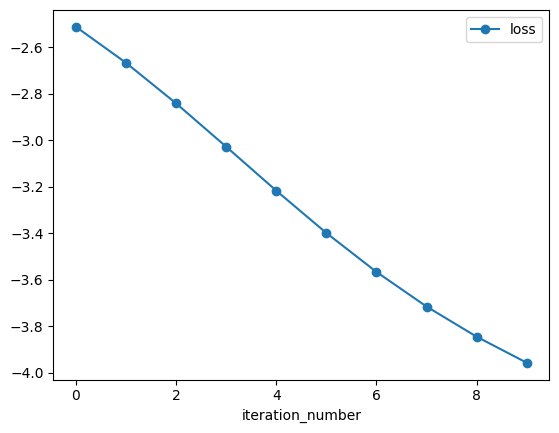

In [23]:
# A demonstration of plotting the metrics
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


df = pd.DataFrame(job.metrics()).sort_values("iteration_number")

ax = plt.figure().gca()
figure = df.plot(x="iteration_number", y="loss", ax=ax, marker="o")

## Continuing from a previous hybrid job with checkpoints

Since we saved a checkpoint in the hybrid job, we can create a new hybrid job to resume by loading the data from that checkpoint.
This next hybrid job adds an additional 10 steps to the QAOA training.

In [24]:
from braket.jobs import load_job_checkpoint

@hybrid_job(device=None, input_data=input_file_path, copy_checkpoints_from_job=previous_job_arn)
def continued_run_qaoa_hybrid_job(p=1, steps=10):

    # Resume from last checkpoint
    checkpoint = load_job_checkpoint(previous_job_name)

    start_iteration = checkpoint["iteration"]
    params = checkpoint["params"]
    cost = checkpoint["cost"]

    # code below is similar for both hybrid jobs
    braket_task_tracker = Tracker()

    graph = nx.read_adjlist(input_file_path, nodetype=int)
    wires = list(graph.nodes)

    cost_h, mixer_h = qaoa.maxcut(graph)

    dev = qml.device("default.qubit", wires=len(wires))

    @qml.qnode(dev)
    def cost_function(params):
        circuit(params)
        return qml.expval(cost_h)

    # training loop
    optimizer = qml.GradientDescentOptimizer()
    for i in range(start_iteration, steps):  # start from checkpoint
        params = optimizer.step(cost_function, params)
        cost = float(cost_function(params))

        log_metric(metric_name="loss", value=cost, iteration_number=i)

    np.save("continued_optimal_params.npy", params)

    return {
        "params": params,
        "cost": float(cost),
        "task summary": braket_task_tracker.quantum_tasks_statistics(),
        "estimated cost": braket_task_tracker.qpu_tasks_cost()
        + braket_task_tracker.simulator_tasks_cost(),
    }

In [25]:
continued_job = continued_run_qaoa_hybrid_job(p=1, steps=20)
print(continued_job)

AwsQuantumJob('arn':'arn:aws:braket:us-west-1:961591465522:job/continued-run-qaoa-hybrid-job-1697309651121')


In [26]:
%%time

continued_result = continued_job.result()

In [ ]:
time.sleep(10)

continued_job.metrics()

In [ ]:
df = pd.DataFrame(job.metrics())
df = pd.DataFrame(continued_job.metrics())
# continued_df["iteration_number"] += 10

df = pd.concat([df, continued_df], ignore_index=True).sort_values("iteration_number")
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
figure = df.plot(x="iteration_number", y="loss", ax=ax, marker="o")

We see how adding 10 more iterations has improved the convergence significantly. 

In [ ]:
print(f"Estimated cost to run quantum tasks in this notebook: {job.result()['estimated cost'] + continued_job.result()['estimated cost']} USD")

## Summary

In this tutorial, we set up a Max-Cut problem with a random graph using PennyLane. 
We saved the graph to a local file and provided it as input data to our hybrid job.
Hyperparameters required for the algorithm are passed in as function arguments. 
The result is retrieved after the QAOA algorithm is completed. 
Lastly, we demonstrated how to use checkpoints to save and load training progress of a hybrid job.